In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/Colab_Notebooks/BMET5933_Lab/chest_xray_full_dataset.zip'

if os.path.exists(dataset_path):
    print("Dataset directory found!")
else:
    print("Dataset directory not found. Check your Google Drive path!")

Mounted at /content/drive
Dataset directory found!


In [ ]:
import zipfile
import os

zip_file_path = '/content/drive/MyDrive/Colab_Notebooks/BMET5933_Lab/chest_xray_full_dataset.zip'
destination_path = '/content/chest_xray/'

if os.path.exists(zip_file_path):
    print("ZIP file found, starting extraction...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(destination_path)
    print(f"Dataset extracted to: {destination_path}")
else:
    print("ZIP file not found. Check the file path!")

ZIP file found, starting extraction...
Dataset extracted to: /content/chest_xray/


In [ ]:
import numpy as np
from scipy.stats import entropy as calculate_entropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters for resizing and augmentation
IMG_SIZE = (256, 256)  # Uniform image size
ROI_SIZE = (28, 28)    # Each ROI will be 28x28 pixels (8x8 grid -> 64 ROIs)

# Initialize ImageDataGenerator with augmentation techniques
data_gen = ImageDataGenerator(
    rescale=1./255,                         # Normalize pixel values to [0, 1]
    horizontal_flip=True,                   # Random horizontal reflection
    shear_range=15,                         # Random shear (horizontal and vertical within 0°-15°)
    rotation_range=3,                       # Random rotation between −3° to 3°
    validation_split=0.2                    # Split into training and validation
)

# Preprocessing the training images
train_gen = data_gen.flow_from_directory(
    '/content/chest_xray/chest_xray/train',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='binary',      # (NORMAL=0, PNEUMONIA=1)
    subset='training'         # Training subset
)

# Modified Min-Max Scaling
def normalize_features(features):
    """Scale features between 0 and 1 using Min-Max scaling."""
    features = np.array(features)
    min_vals = np.min(features, axis=0)
    max_vals = np.max(features, axis=0)
    # Avoid division by zero by setting a small epsilon for constant features
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1e-10  # Replace zero ranges with a small value
    return (features - min_vals) / range_vals

def calculate_features(image):
    """Divide an image into 64 ROIs and extract statistical features from each ROI."""
    features = []
    h, w = image.shape
    step_x, step_y = w // 8, h // 8  # Divide into 8x8 grid (64 ROIs)

    for y in range(0, h, step_y):
        for x in range(0, w, step_x):
            roi = image[y:y+step_y, x:x+step_x]

            # Statistical Features
            roi_flat = roi.flatten()
            max_val = np.max(roi_flat)
            min_val = np.min(roi_flat)
            mean_val = np.mean(roi_flat)
            mode_val = np.argmax(np.bincount(roi_flat.astype(int)))  # Convert to integers for mode
            std_val = np.std(roi_flat)
            q_2_5 = np.percentile(roi_flat, 2.5)
            q_5 = np.percentile(roi_flat, 5)
            q_10 = np.percentile(roi_flat, 10)
            q_90 = np.percentile(roi_flat, 90)
            q_95 = np.percentile(roi_flat, 95)
            q_97_5 = np.percentile(roi_flat, 97.5)
            abs_energy = np.sum(roi_flat**2)

            # Entropy (using pixel intensity histogram)
            hist, _ = np.histogram(roi_flat, bins=256, range=(0, 1), density=True)
            hist = hist + 1e-10  # Avoid log(0)
            entropy_val = calculate_entropy(hist, base=2)

            # Append features from this ROI
            features.extend([max_val, min_val, mean_val, mode_val, std_val,
                             q_2_5, q_5, q_10, q_90, q_95, q_97_5, abs_energy, entropy_val])

    return features

# Iterate over training images and extract features
all_features = []
labels = []

for images, batch_labels in train_gen:  # Loop through batches of images
    for i in range(images.shape[0]):  # Loop through images in the batch
        image = images[i].squeeze()  # Remove single channel dimension (grayscale)
        features = calculate_features(image)  # Extract features from 64 ROIs
        all_features.append(features)
        labels.append(batch_labels[i])
    if len(all_features) >= train_gen.samples:  # Stop after processing all training samples
        break

# Convert to NumPy arrays and normalize features
all_features = np.array(all_features)
labels = np.array(labels)

# Apply the modified Min-Max scaling
scaled_features = normalize_features(all_features)

# Save features and labels
np.save('scaled_features.npy', scaled_features)
np.save('labels.npy', labels)

print(f"Extracted features shape: {scaled_features.shape}")
print(f"Labels shape: {labels.shape}")

Found 4187 images belonging to 2 classes.
Extracted features shape: (4187, 832)
Labels shape: (4187,)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import dump

# Load features and labels
features = np.load('scaled_features.npy')
labels = np.load('labels.npy')

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train a SVM classifier
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)

print(" SVM classifier trained successfully!")

# Save the trained model
dump(svm_model, 'svm_classifier.joblib')
print(" SVM model saved using joblib!")

# Predict using the trained classifier
y_pred = svm_model.predict(X_val)

# Evaluate the new model
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Accuracy Score
accuracy = accuracy_score(y_val, y_pred)
print(f"\nValidation Accuracy: {accuracy:.2f}")


 SVM classifier trained successfully!
 SVM model saved using joblib!

Confusion Matrix:
[[203  15]
 [ 15 605]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       218
         1.0       0.98      0.98      0.98       620

    accuracy                           0.96       838
   macro avg       0.95      0.95      0.95       838
weighted avg       0.96      0.96      0.96       838


Validation Accuracy: 0.96


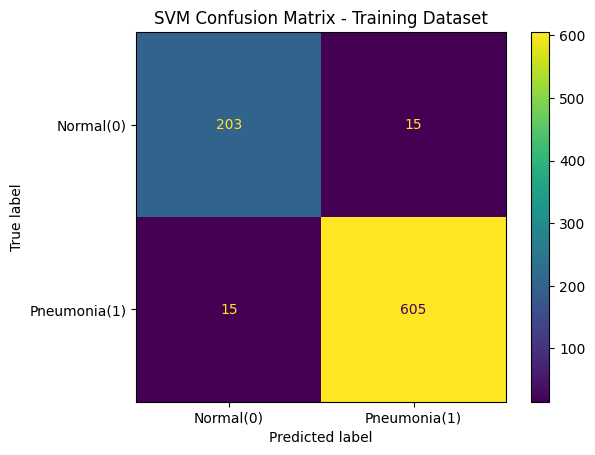

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(svm_model, X_val, y_val, display_labels=['Normal(0)', 'Pneumonia(1)'])
plt.title("SVM Confusion Matrix - Training Dataset")
plt.show()


In [ ]:
import numpy as np
from scipy.stats import entropy as calculate_entropy1
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters for resizing
IMG_SIZE = (256, 256)
ROI_SIZE = (28, 28)

# Initialize ImageDataGenerator for test dataset (only rescaling, no augmentation)
test_data_gen = ImageDataGenerator(rescale=1./255)

# Load test images
test_gen = test_data_gen.flow_from_directory(
    '/content/chest_xray/chest_xray/test',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='binary',  # (NORMAL=0, PNEUMONIA=1)
    shuffle=False  # Keep images in original order
)

print(f"Found {test_gen.samples} images in the test dataset.")

# Function to normalize features
def normalize_features(features):
    """Scale features between 0 and 1 using Min-Max scaling."""
    features = np.array(features)
    min_vals = np.min(features, axis=0)
    max_vals = np.max(features, axis=0)
    # Avoid division by zero by setting a small epsilon for constant features
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1e-10  # Replace zero ranges with a small value
    return (features - min_vals) / range_vals

# Function to extract features from ROIs
def calculate_features(image):
    """Divide an image into 64 ROIs and extract statistical features from each ROI."""
    features = []
    h, w = image.shape
    step_x, step_y = w // 8, h // 8  # Divide into 8x8 grid (64 ROIs)

    for y in range(0, h, step_y):
        for x in range(0, w, step_x):
            roi = image[y:y+step_y, x:x+step_x]

            # Statistical Features
            roi_flat = roi.flatten()
            max_val = np.max(roi_flat)
            min_val = np.min(roi_flat)
            mean_val = np.mean(roi_flat)
            mode_val = np.argmax(np.bincount(roi_flat.astype(int)))  # Convert to integers for mode
            std_val = np.std(roi_flat)
            q_2_5 = np.percentile(roi_flat, 2.5)
            q_5 = np.percentile(roi_flat, 5)
            q_10 = np.percentile(roi_flat, 10)
            q_90 = np.percentile(roi_flat, 90)
            q_95 = np.percentile(roi_flat, 95)
            q_97_5 = np.percentile(roi_flat, 97.5)
            abs_energy = np.sum(roi_flat**2)

            # Entropy (using pixel intensity histogram)
            hist, _ = np.histogram(roi_flat, bins=256, range=(0, 1), density=True)
            hist = hist + 1e-10  # Avoid log(0)
            entropy_val = calculate_entropy1(hist, base=2)

            # Append features from this ROI
            features.extend([max_val, min_val, mean_val, mode_val, std_val,
                             q_2_5, q_5, q_10, q_90, q_95, q_97_5, abs_energy, entropy_val])

    return features

# Iterate over test images and extract features
test_features = []
test_labels = []  # (0: NORMAL, 1: PNEUMONIA)

for images, batch_labels in test_gen:  # Loop through test batches
    for i in range(images.shape[0]):  # Iterate through images
        image = images[i].squeeze()  # Remove single channel dimension (grayscale)
        features = calculate_features(image)  # Extract features
        test_features.append(features)
        test_labels.append(batch_labels[i])  # Store label

    if len(test_features) >= test_gen.samples:  # Stop after all images are processed
        break

# Convert to NumPy arrays and normalize features
test_features = np.array(test_features)
test_labels = np.array(test_labels)

# Apply the modified Min-Max scaling
scaled_test_features = normalize_features(test_features)

# Save extracted test features & labels
np.save('test_features.npy', scaled_test_features)
np.save('test_labels.npy', test_labels)

print(f"Extracted test features shape: {scaled_test_features.shape}")
print(f"Test labels shape: {test_labels.shape}")

Found 624 images belonging to 2 classes.
Found 624 images in the test dataset.
Extracted test features shape: (624, 832)
Test labels shape: (624,)


In [ ]:
from joblib import load
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load trained SVM classifier
svm_model = load('svm_classifier.joblib')

# Load test features & labels
X_test = np.load('test_features.npy')
y_test = np.load('test_labels.npy')

# Make predictions
y_test_pred = svm_model.predict(X_test)

# Evaluate results
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Accuracy: {test_accuracy:.2f}")


Confusion Matrix:
[[183  51]
 [  7 383]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.78      0.86       234
         1.0       0.88      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.88      0.90       624
weighted avg       0.91      0.91      0.90       624


Test Accuracy: 0.91


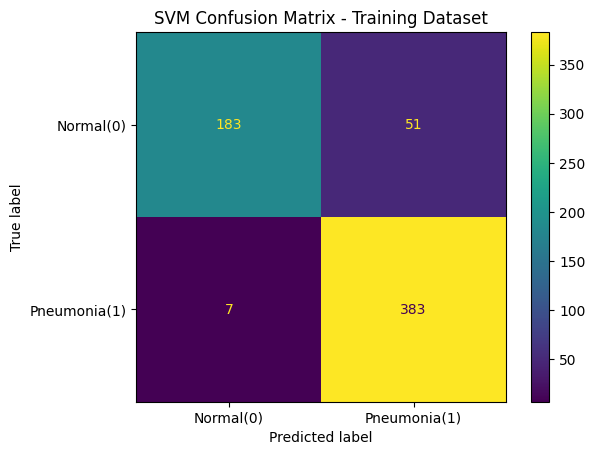

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(svm_model, X_test, y_test, display_labels=['Normal(0)', 'Pneumonia(1)'])
plt.title("SVM Confusion Matrix - Training Dataset")
plt.show()
